In [1]:
import onnxruntime as ort
import numpy as np
import matplotlib.pyplot as plt
import ee
import geemap

batch_size = 1 
input_shape = (batch_size, 256, 256, 6)
input_data = np.random.rand(*input_shape).astype(np.float32)

session = ort.InferenceSession("weights/rgbnirswirs.onnx")

predictions = session.run(['output_0'], {'inputs': input_data})[0]

In [2]:
ee.Authenticate(quiet=True)

True

In [3]:
ee.Initialize()

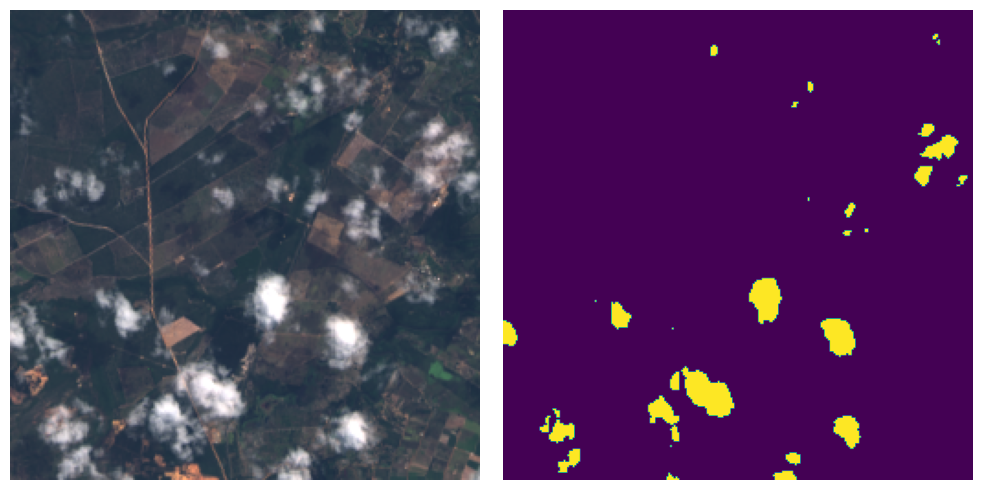

In [5]:
region = ee.Geometry.Polygon(
    [
        [
            [-45.0, -12.0],
            [-45.0, -12.1],
            [-44.9, -12.1],
            [-44.9, -12.0],
        ]
    ]
)

# Carregue uma imagem Landsat 8
image = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA') \
    .filterBounds(region) \
    .filterDate('2023-05-01', '2023-06-01') \
    .median() \
    .select(['B4', 'B3', 'B2', 'B5', 'B6', 'B7'])

array = geemap.ee_to_numpy(image, region=region, scale=30)[:256, :256, :]

batch = np.expand_dims(array, axis=0)
prediction = session.run(['output_0'], {'inputs': batch})[0][0,:,:,0]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(np.clip(np.pi*array[:,:,:3], 0, 1))
ax[1].imshow(prediction>0.5)

for axx in ax:
    axx.axis('off')

fig.tight_layout()
plt.show()

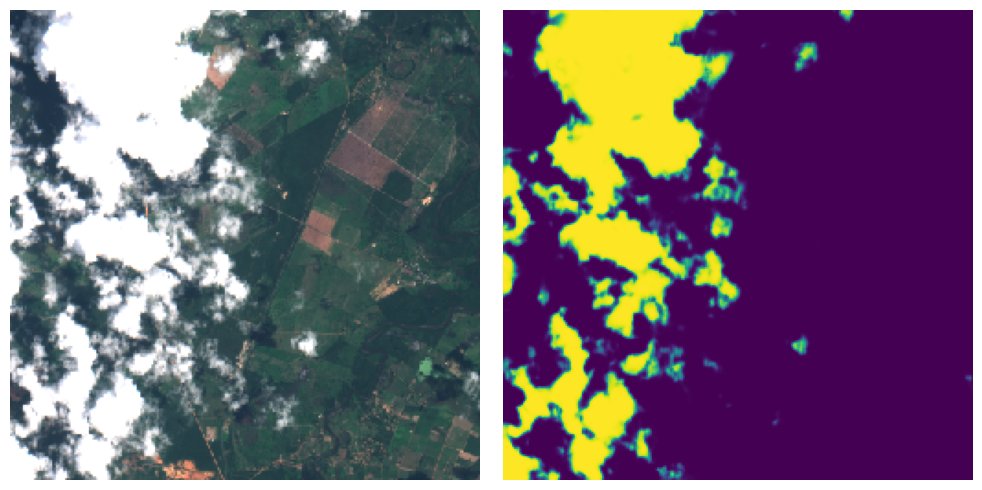

In [14]:
image = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
    .filterBounds(region) \
    .filterDate('2023-02-05', '2023-02-15') \
    .first() \
    .select(['B4', 'B3', 'B2', 'B8', 'B11', 'B12']) \
    .divide(10000)  # Adicionadas as bandas SWIR1 (B11) e SWIR2 (B12)

array = geemap.ee_to_numpy(image, region=region, scale=30).astype(np.float32)

batch = np.expand_dims(array[:256, :256, :], axis=0)
prediction = session.run(['output_0'], {'inputs': batch})[0][0, :, :, 0]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(np.clip(np.pi * array[:256, :256, :3], 0, 1))  # Visualização RGB
ax[1].imshow(prediction, vmin=0, vmax=1)

for axx in ax:
    axx.axis('off')

fig.tight_layout()
plt.show()

In [8]:
session.run(['output_0'], {'inputs': batch})[0].shape

(1, 256, 256, 1)

In [15]:
def find_padding(dim, patch_size=256):
    pad_before = (patch_size - dim % patch_size) // 2
    pad_after = patch_size - dim % patch_size - pad_before
    return pad_before, pad_after

def predictbypatches(predict_fn, image, patch_size=256):
    pad_r = find_padding(image.shape[0], patch_size)
    pad_c = find_padding(image.shape[1], patch_size)
    padded_image = np.pad(image, ((pad_r[0], pad_r[1]), (pad_c[0], pad_c[1]), (0, 0)), 'reflect')

    patches = []
    for i in range(0, padded_image.shape[0], patch_size):
        for j in range(0, padded_image.shape[1], patch_size):
            patch = padded_image[i:i + patch_size, j:j + patch_size, :]
            patches.append(patch)
    
    patches = np.array(patches)
    predictions = predict_fn(patches)
    
    prediction = np.zeros(padded_image.shape[:2], dtype=np.float32)
    idx = 0
    for i in range(0, padded_image.shape[0], patch_size):
        for j in range(0, padded_image.shape[1], patch_size):
            prediction[i:i + patch_size, j:j + patch_size] = predictions[idx]
            idx += 1
    
    slice_rows = slice(pad_r[0], None if pad_r[1] <= 0 else -pad_r[1])
    slice_cols = slice(pad_c[0], None if pad_c[1] <= 0 else -pad_c[1])
    return prediction[slice_rows, slice_cols]

In [16]:
def predict_fn(patches):
    return session.run(['output_0'], {'inputs': patches})[0][..., 0]

prediction = predictbypatches(predict_fn, array)

plt.imshow(prediction, vmin=0, vmax=1)

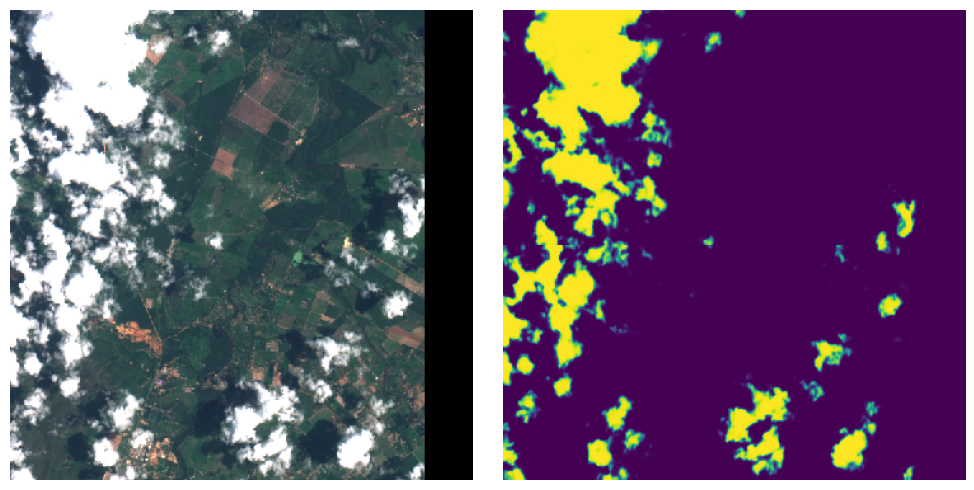

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(np.clip(np.pi * array[:, :, :3], 0, 1))
ax[1].imshow(predictbypatches(predict_fn, array), vmin=0, vmax=1)

for axx in ax:
    axx.axis('off')

fig.tight_layout()
plt.show()